Nadea putri Nur Fauzi

Kelas Ular

AI Mastery Program

# Import Library

In [ ]:
import time
import datetime
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

%load_ext tensorboard

# Download model Classifier dari TFHub

In [ ]:
mobilenet_v3 ="https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

classifier_model = mobilenet_v3

In [ ]:
img_shape = (224, 224)

classifier = tf.keras.Sequential([hub.KerasLayer(classifier_model, input_shape=img_shape+(3,))])

# Load Dataset

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = '/content/drive/My Drive/dataset/4-animal-classification/train'

In [ ]:
data

'/content/drive/My Drive/dataset/4-animal-classification/train'

Preprocessing data (Mengganti parameter data)

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_gen = tf.keras.utils.image_dataset_from_directory(
  str(data),
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_gen = tf.keras.utils.image_dataset_from_directory(
  str(data),
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2800 files belonging to 4 classes.
Using 2240 files for training.
Found 2800 files belonging to 4 classes.
Using 560 files for validation.


In [ ]:
class_names = np.array(train_gen.class_names)
print(class_names)

['cat' 'deer' 'dog' 'horse']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_gen = train_gen.map(lambda x, y: (normalization_layer(x), y)) 
val_gen = val_gen.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_gen = train_gen.cache().prefetch(buffer_size=AUTOTUNE)
val_gen = val_gen.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_gen:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


Data dengan batch_size = 32 dengan size 224x224 dan depth = 3

# Download Headless Model dari TFHub

In [ ]:
mobilenet_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"

feature_extractor_model = mobilenet_v3

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=True,
    arguments=dict(batch_norm_momentum=0.997)
    )

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4226432   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,231,556
Trainable params: 4,207,156
Non-trainable params: 24,400
_________________________________________________________________


# Train Model Klasifikasi

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

log_dir = "logs/fits/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [ ]:
epochs = 20

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    callbacks=tensorboard_callback)

Epoch 1/20
70/70 [==============================] - 499s 7s/step - loss: 0.6242 - accuracy: 0.8687 - val_loss: 0.9098 - val_accuracy: 0.8857
Epoch 2/20
70/70 [==============================] - 15s 220ms/step - loss: 0.3378 - accuracy: 0.9759 - val_loss: 0.7417 - val_accuracy: 0.9196
Epoch 3/20
70/70 [==============================] - 16s 224ms/step - loss: 0.3138 - accuracy: 0.9817 - val_loss: 0.7762 - val_accuracy: 0.9071
Epoch 4/20
70/70 [==============================] - 15s 220ms/step - loss: 0.3392 - accuracy: 0.9714 - val_loss: 1.0730 - val_accuracy: 0.8857
Epoch 5/20
70/70 [==============================] - 15s 221ms/step - loss: 0.3370 - accuracy: 0.9754 - val_loss: 1.7515 - val_accuracy: 0.8643
Epoch 6/20
70/70 [==============================] - 15s 220ms/step - loss: 0.3404 - accuracy: 0.9723 - val_loss: 1.2616 - val_accuracy: 0.8304
Epoch 7/20
70/70 [==============================] - 16s 224ms/step - loss: 0.2843 - accuracy: 0.9915 - val_loss: 0.9559 - val_accuracy: 0.8821
E

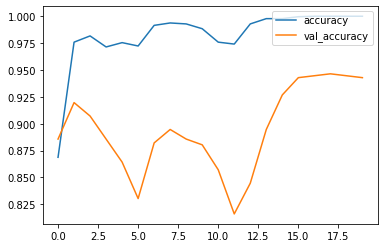

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

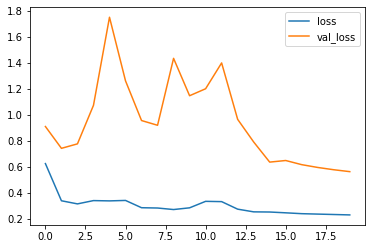

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()

# Submission

In [ ]:
sub_csv ='/content/drive/My Drive/dataset/4-animal-classification/Sample_submission.csv'
path_test = '/content/drive/My Drive/dataset/4-animal-classification/test'

#ini buat ngebaca data csv submission sama data test yang gambar

In [ ]:
import pandas as pd

df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))

#ini predict sama ngubah parameter gambar samain kek yg di train

In [ ]:
df_sub['Label'] = labels
df_sub.head(10)

#ini output predict

In [ ]:
df_sub.to_csv('submitketiga.csv',index=False)